In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import math
import csv
import xgboost
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

In [91]:
feature_list = pd.DataFrame()

In [231]:
trainData = pd.read_csv('train_v2.csv', parse_dates=['Date'], dtype={'StateHoliday': 'str'})
testData = pd.read_csv('test_v2.csv',  parse_dates=['Date'], dtype={'StateHoliday': 'str'})
storeData = pd.read_csv('store.csv')
trainData = pd.merge(trainData, storeData, on="Store")
testData = testData.reset_index().merge(storeData,on='Store')
index = testData['index']
testData.drop('index', axis=1, inplace=True)
trainData = trainData[trainData.Customers != 0]

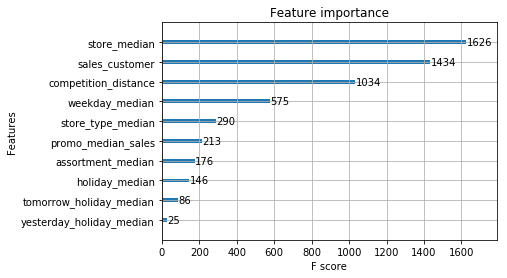

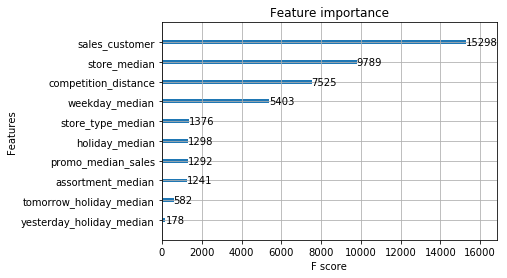

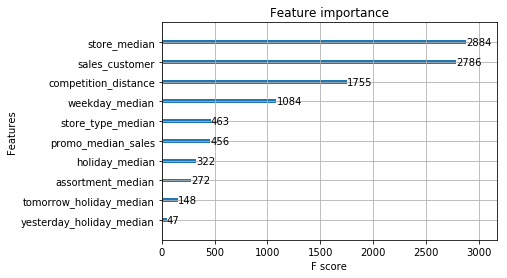

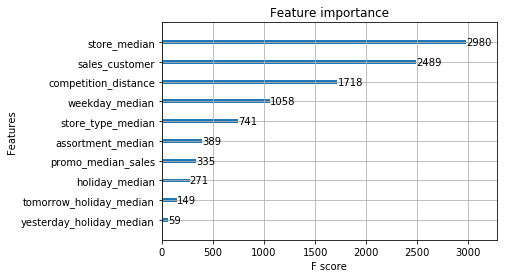

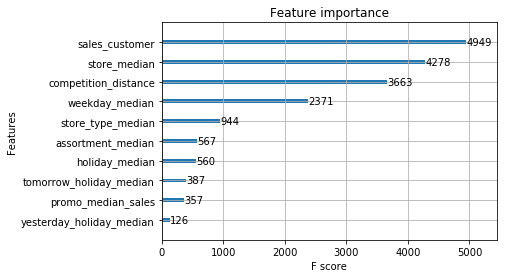

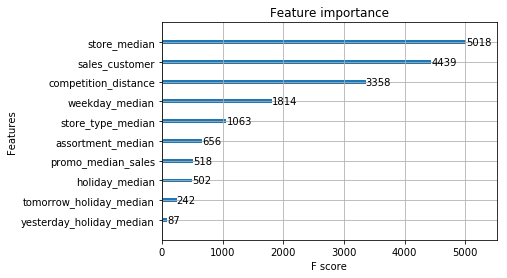

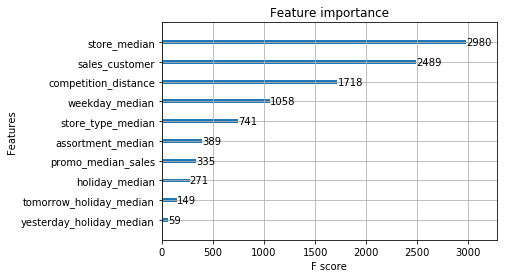

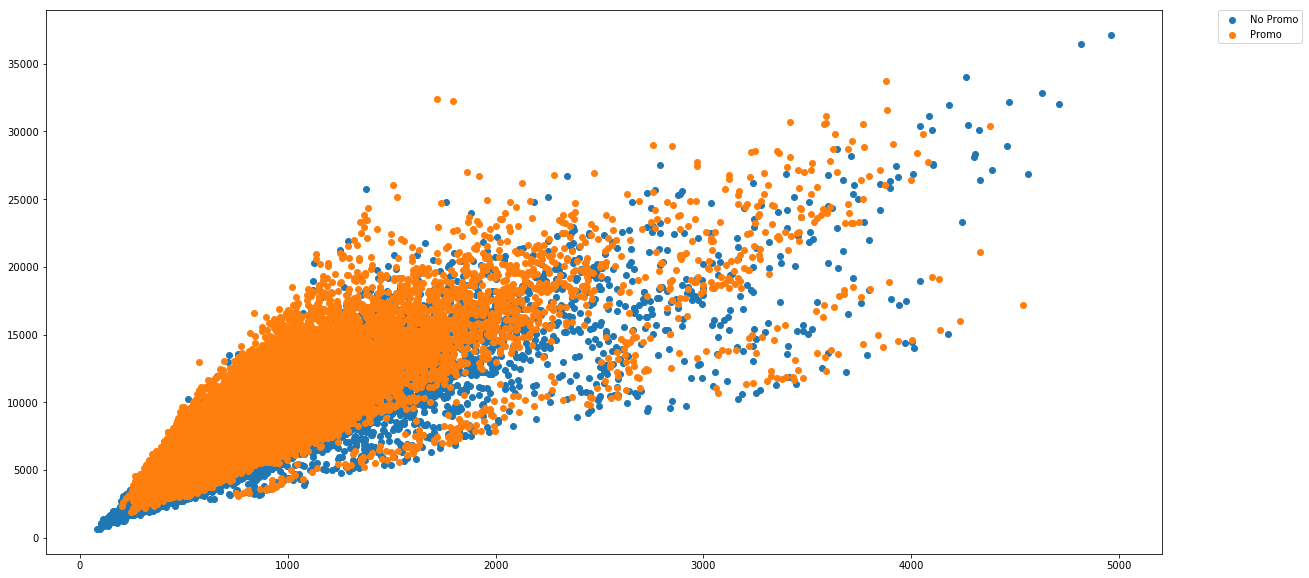

In [232]:
pl.figure(figsize=(20,10))
pl.scatter(trainData[trainData.Promo == 0].Customers, trainData[trainData.Promo == 0].Sales, label="No Promo")
pl.scatter(trainData[trainData.Promo == 1].Customers, trainData[trainData.Promo == 1].Sales, label="Promo")
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pl.show()

In [233]:
# Feature 1: Sales-customer relationship of a store
X = trainData.Customers.values.reshape(-1,1)
y = trainData.Sales.values.reshape(-1,1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
sales_customer_lr = LinearRegression()
clf = sales_customer_lr.fit(X_train, y_train)
print("Cross validation score: " + str(clf.score(X_val, y_val)))
sales_customer_lr.fit(X,y)
df = pd.DataFrame(sales_customer_lr.predict(X))
feature_list["sales_customer"] = df[0]

Cross validation score: 0.710035272297


In [234]:
# Feature 2: Median of a store
medianOfStore = trainData.groupby("Store").median().Sales
def getMedianOfStore(row):
    return medianOfStore.iloc[row["Store"] - 1]
df = pd.DataFrame()
df["store_median"] = trainData[trainData.Customers != 0].apply(lambda row: getMedianOfStore(row), axis=1)
df.index = range(len(df))
feature_list["store_median"] = df["store_median"]

In [235]:
# Feature 3: Median of a weekday
def getWeekDay(row):
    return row["Date"].weekday()
_trainData = pd.DataFrame()
_trainData["Sales"] = trainData["Sales"]
_trainData["Weekday"] = trainData.apply(lambda row: getWeekDay(row), axis=1)
medianOfWeekday = _trainData.groupby("Weekday").median().Sales
def getWeekDayMedian(row):
    return medianOfWeekday.iloc[row["Weekday"]]
_trainData["weekday_median"] = _trainData.apply(lambda row: getWeekDayMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["weekday_median"] = _trainData["weekday_median"]

In [236]:
# Feature 4: Median Sales with/out promo
medianSalesPromo = trainData.groupby("Promo").Sales.median()
def getPromoMedian(row):
    return medianSalesPromo.iloc[row["Promo"]]
_trainData = pd.DataFrame()
_trainData["promo_median_sales"] = trainData.apply(lambda row: getPromoMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["promo_median_sales"] = _trainData["promo_median_sales"]

In [250]:
# Feature 5: Median sales from store type
storeTypeMedian = trainData.groupby("StoreType").Sales.median()
storeTypeToLoc = {"a":0,"b":1,"c":2,"d":3}
def getStoreTypeMedian(row):
    return storeTypeMedian.iloc[storeTypeToLoc[row["StoreType"]]]
_trainData = pd.DataFrame()
_trainData["store_type_median"] = trainData.apply(lambda row: getStoreTypeMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["store_type_median"] = _trainData["store_type_median"]

In [238]:
# Feature 6: Median sales from assortment
assortmentMedian = trainData.groupby("Assortment").Sales.median()
storeTypeToLoc = {"a":0,"b":1,"c":2}
def getAssortmentMedian(row):
    return assortmentMedian.iloc[storeTypeToLoc[row["Assortment"]]]
_trainData = pd.DataFrame()
_trainData["assortment_median"] = trainData.apply(lambda row: getAssortmentMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["assortment_median"] = _trainData["assortment_median"]

In [239]:
# Feature 7: Competition
feature_list["competition_distance"] = trainData["CompetitionDistance"]
feature_list.fillna(0, inplace=True)

In [240]:
# Feature 8: Median sales for holiday
def hasHoliday(row):
    if row["StateHoliday"] == "0" and row["SchoolHoliday"] == 0:
        return 0
    else:
        return 1

_trainData = pd.DataFrame()
_trainData["Holiday"] = trainData.apply(lambda row: hasHoliday(row), axis=1)
_trainData["Sales"] = trainData["Sales"]
holidayMedian = _trainData.groupby("Holiday").Sales.median()
def getHolidayMedian(row):
    return holidayMedian.iloc[row["Holiday"]]
_trainData["holiday_median"] = _trainData.apply(lambda row: getHolidayMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["holiday_median"] = _trainData["holiday_median"]

In [241]:
# Feature 9: Median sales for holiday that is between the current day
def isTomorrowHoliday(row):
    current = row['isTomorrowHoliday']
    if (row['Date'].to_pydatetime() + timedelta(1) == row['previousRowDate']):
        return int(current)
    else:
        return 0
def isYesterdayHoliday(row):
    current = row['isYesterdayHoliday']
    if (row['Date'].to_pydatetime() - timedelta(1) == row['nextRowDate']):
        return int(current)
    else:
        return 0
_trainData = pd.DataFrame()
_trainData["Holiday"] = trainData.apply(lambda row: hasHoliday(row), axis=1)
_trainData["Sales"] = trainData["Sales"]
_trainData["Date"] = trainData["Date"]
_trainData['previousRowDate'] = _trainData['Date'].shift(1)
_trainData['nextRowDate'] = _trainData['Date'].shift(-1)
_trainData['isTomorrowHoliday'] = _trainData['Holiday'].shift(1)
_trainData['isYesterdayHoliday'] = _trainData['Holiday'].shift(-1)
_trainData['isTomorrowHoliday'] = _trainData.apply(lambda row: isTomorrowHoliday(row), axis=1)
_trainData['isYesterdayHoliday'] = _trainData.apply(lambda row: isYesterdayHoliday(row), axis=1)
tomorrowHolidayMedian = _trainData.groupby("isTomorrowHoliday").Sales.median()
yesterdayHolidayMedian = _trainData.groupby("isYesterdayHoliday").Sales.median()
def getTomorrowHolidayMedian(row):
    return tomorrowHolidayMedian.iloc[row["isTomorrowHoliday"]]
def getYesterdayHolidayMedian(row):
    return yesterdayHolidayMedian.iloc[row["isTomorrowHoliday"]]
_trainData["tomorrow_holiday_median"] = _trainData.apply(lambda row: getTomorrowHolidayMedian(row), axis=1)
_trainData["yesterday_holiday_median"] = _trainData.apply(lambda row: getYesterdayHolidayMedian(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["tomorrow_holiday_median"] = _trainData["tomorrow_holiday_median"]
feature_list["yesterday_holiday_median"] = _trainData["yesterday_holiday_median"]

In [263]:
# Feature 10: Promo 2 NEED TO BE MORE PERSONAL
month_num_name_dict = {
    "1": "Jan",
    "2": "Feb",
    "3": "Mar",
    "4": "Apr",
    "5": "May",
    "6": "Jun",
    "7": "Jul",
    "8": "Aug",
    "9": "Sept",
    "10": "Oct",
    "11": "Nov",
    "12": "Dec"
}
def isHavingPromo2(row):
    if not isinstance(row['PromoInterval'], str):
        return 0
    elif month_num_name_dict[str(row['Date'].to_pydatetime().month)] in row['PromoInterval']:
        return 1
    else:
        return 0
_trainData = pd.DataFrame()
_trainData['having_promo_2'] = trainData.apply(lambda row: isHavingPromo2(row), axis=1)
_trainData["Sales"] = trainData["Sales"]
havingPromo2Median = _trainData.groupby("having_promo_2").Sales.median()
def promo2Median(row):
    return havingPromo2Median.iloc[row["having_promo_2"]]
_trainData['promo_2_median'] = _trainData.apply(lambda row: promo2Median(row), axis=1)
_trainData.index = range(len(_trainData))
feature_list["promo_2_median"] = _trainData["promo_2_median"]

In [ ]:
# Feature 11: Day Of Month
# TODO

In [299]:
feature_list.shape

(54688, 11)

Cross validation score: 0.953070473702


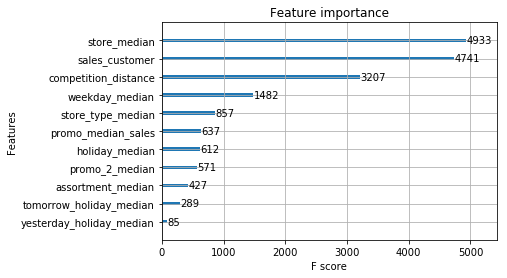

In [290]:
X = feature_list
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
# test = LinearRegression()
# clf = test.fit(X_train, y_train)
# print("Cross validation score: " + str(clf.score(X_val, y_val)))
xgb = XGBRegressor(learning_rate=0.3, subsample=0.75, colsample_bytree=0.75, max_depth=8, gamma=1)
clf = xgb.fit(X_train, y_train, eval_metric="rmse")
print("Cross validation score: " + str(clf.score(X_val, y_val)))
xgboost.plot_importance(xgb).figure

In [244]:
testData.head()
testFeatureList = pd.DataFrame()

In [318]:
X = testData.Customers.values.reshape(-1,1)
df = pd.DataFrame(sales_customer_lr.predict(X))
testFeatureList["sales_customer"] = df[0]
testFeatureList["store_median"] = testData.apply(lambda row: getMedianOfStore(row), axis=1)
_testData = pd.DataFrame()
_testData["Weekday"] = testData.apply(lambda row: getWeekDay(row), axis=1)
_testData["weekday_median"] = _testData.apply(lambda row: getWeekDayMedian(row), axis=1)
testFeatureList["weekday_median"] = _testData["weekday_median"]
_testData = pd.DataFrame()
_testData["promo_median_sales"] = testData.apply(lambda row: getPromoMedian(row), axis=1)
testFeatureList["promo_median_sales"] = _testData["promo_median_sales"]
_testData = pd.DataFrame()
_testData["store_type_median"] = testData.apply(lambda row: getStoreTypeMedian(row), axis=1)
testFeatureList["store_type_median"] = _testData["store_type_median"]
_testData = pd.DataFrame()
_testData["assortment_median"] = testData.apply(lambda row: getAssortmentMedian(row), axis=1)
testFeatureList["assortment_median"] = _testData["assortment_median"]
testFeatureList["competition_distance"] = testData["CompetitionDistance"]
testFeatureList.fillna(0, inplace=True)
_testData = pd.DataFrame()
_testData["Holiday"] = testData.apply(lambda row: hasHoliday(row), axis=1)
_testData["holiday_median"] = _testData.apply(lambda row: getHolidayMedian(row), axis=1)
testFeatureList["holiday_median"] = _testData["holiday_median"]
_testData = pd.DataFrame()
_testData["Holiday"] = testData.apply(lambda row: hasHoliday(row), axis=1)
_testData["Date"] = testData["Date"]
_testData['previousRowDate'] = _testData['Date'].shift(1)
_testData['nextRowDate'] = _testData['Date'].shift(-1)
_testData['isTomorrowHoliday'] = _testData['Holiday'].shift(1)
_testData['isYesterdayHoliday'] = _testData['Holiday'].shift(-1)
_testData['isTomorrowHoliday'] = _testData.apply(lambda row: isTomorrowHoliday(row), axis=1)
_testData['isYesterdayHoliday'] = _testData.apply(lambda row: isYesterdayHoliday(row), axis=1)
_testData["tomorrow_holiday_median"] = _testData.apply(lambda row: getTomorrowHolidayMedian(row), axis=1)
_testData["yesterday_holiday_median"] = _testData.apply(lambda row: getYesterdayHolidayMedian(row), axis=1)
testFeatureList["tomorrow_holiday_median"] = _testData["tomorrow_holiday_median"]
testFeatureList["yesterday_holiday_median"] = _testData["yesterday_holiday_median"]
_testData = pd.DataFrame()
_testData['having_promo_2'] = testData.apply(lambda row: isHavingPromo2(row), axis=1)
_testData['promo_2_median'] = _testData.apply(lambda row: promo2Median(row), axis=1)
_testData.index = range(len(_testData))
testFeatureList["promo_2_median"] = _testData["promo_2_median"]

In [319]:
testFeatureList.shape

(33450, 11)

In [293]:
results = xgb.predict(testFeatureList)

(33450,)

In [332]:
store_closed_index = np.where(testData.Customers == 0)
print(store_closed_index)
for val in store_closed_index:
    results[val] = 1
with open('submission.csv', 'w') as csvfile:
    fieldnames = ['Id', 'Sales']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for idx, val in enumerate(results):
        writer.writerow({'Id': index[idx] + 1, 'Sales': val})
    csvfile.close()

(array([    5,    12,    19, ..., 33432, 33439, 33446]),)
